## Transversely isotropic viscosity

This notebook uses compressional boundary conditions to reproduce the results from Sharples et al, 2016 (I think).

Apply compressional stresses to a region with transversely isotropic material. If the orientation of the director is oriented parallel / perpendicular to the compressive principle stress direction then the 1st viscosity should be the only active parameter; if at 45 degrees then only the second viscosity will be active. 

This should be reflected in the stress state ... but note that the current machinery is not very helpful in obtaining stress except when there is a scalar viscosity.

In [1]:
try :
    if(__IPYTHON__) :
        get_ipython().magic(u'matplotlib inline')
except NameError :
    pass

import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import math
import os

import underworld as uw
from underworld import function as fn
from underworld import meshvariable as meshvariable
import glucifer

import mpi4py
comm = mpi4py.MPI.COMM_WORLD

In [2]:
# As a precaution ... keep workdir. Something in uw is cd'ing to crazy places within the python installation. 
# It seems to be gLucifer.

try:
    workdir
except NameError:
    workdir = os.path.abspath(".")
      
outputPath = os.path.join(workdir,"TransIsoCompression/")

if uw.rank() == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
comm.Barrier()   


Create mesh and finite element variables
------

Note: the use of a pressure-sensitive rheology suggests that it is important to use a Q2/dQ1 element 

In [3]:
minX  = -2.0;   minY = 0.0
maxX  =  2.0;   maxY = 1.0
minXv =  1.0
maxXv = -1.0

resX = 128
resY = 64

elementType="Q2/dPc1"  # This is enough for a test but not to use the code in anger

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, minY), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 



velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

### Boundary conditions

Pure shear with moving  side walls — all boundaries are zero traction with outflow top and bottom
to accommodate changing volume

In [4]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base   = mesh.specialSets["MinJ_VertexSet"]
top    = mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

velocityBCs = uw.conditions.DirichletCondition( variable        = velocityField, 
                                                indexSetsPerDof = (iWalls, iWalls) )

for index in mesh.specialSets["MinI_VertexSet"]:
    velocityField.data[index] = [minXv, 0.]
for index in mesh.specialSets["MaxI_VertexSet"]:
    velocityField.data[index] = [maxXv, 0.]
    

### Setup the material swarm and passive tracers

The material swarm is used for tracking deformation and history dependence of the rheology

Passive swarms can track all sorts of things but lack all the machinery for integration and re-population

In [5]:
swarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

# For population control, make this an integration swarm
popSwarm = uw.swarm.VoronoiIntegrationSwarm(swarm, particlesPerCell=50)

surfaceSwarm = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
deformationSwarm = uw.swarm.Swarm ( mesh=mesh, particleEscape=True )

### Add swarm variables

We are using a single material with a single rheology. We need to track the plastic strain in order to have some manner of strain-related softening (e.g. of the cohesion or the friction coefficient). For visualisation of swarm data we need an actual swarm variable and not just the computation.

Other variables are used to track deformation in the shear band etc.

**NOTE**:  Underworld needs all the swarm variables defined before they are initialised or there will be / can be memory problems (at least it complains about them !). That means we need to add the monitoring variables now, even if we don't always need them.

In [7]:
# Tracking different materials

materialVariable = swarm.add_variable( dataType="int", count=1 )

# Tracking the director orientation

directorVector   = swarm.add_variable( dataType="double", count=2)

pass

### Initialise swarm variables

(Other than the material distribution)

In [8]:
orientation = -45.0 * math.pi / 180.0 
directorVector.data[:,0] = math.cos(orientation)
directorVector.data[:,1] = math.sin(orientation)

### Material distribution in the domain.



In [9]:
# Initialise the 'materialVariable' data to represent different materials. 
materialA  = 0 # accommodation layer a.k.a. Sticky Air
materialV  = 1 # Squasher blocks
materialTI = 2 # Sample (transversely isotropic)

# The particle coordinates will be the input to the function evaluate (see final line in this cell).
# We get proxy for this now using the input() function.

coord = fn.input()
xCoord = fn.coord()[0]
yCoord = fn.coord()[1]

# Setup the conditions list for the following conditional function. Where the
# z coordinate (coordinate[1]) is less than the perturbation, set to lightIndex.

conditions = [ (       yCoord > 0.75 ,                     materialA ),
               (       yCoord < 0.25 ,                     materialA ),
               (       fn.math.abs( xCoord ) < 0.1,        materialTI),
               (       True ,                              materialV ) ]

# The actual function evaluation. Here the conditional function is evaluated at the location
# of each swarm particle. The results are then written to the materialVariable swarm variable.

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)



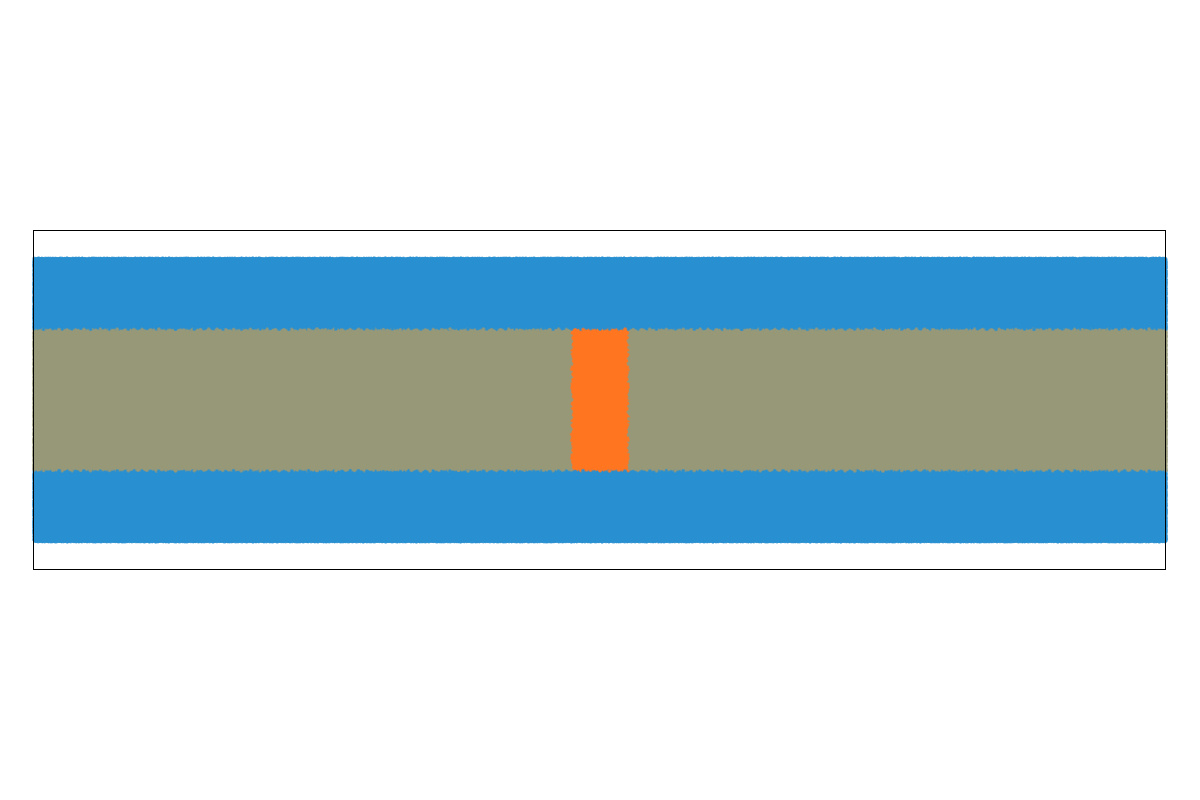

In [10]:
## Take a look at the locations of the materials

figMaterials = glucifer.Figure( figsize=(1200,800), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )
figMaterials.append( glucifer.objects.Points(swarm, materialVariable, pointSize=5.0, colourBar=False) )
figMaterials.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colourBar=False, colours="#440000 #440000") )
figMaterials.show()

### Define the viscosity function

In this case, the viscosity of material which has not reached the yield criterion is simply going to be a constant. Nevertheless, it is useful to define it here as a function and write the remaining code such that it is not changed if we introduce additional materials or a dependence on another set of equations.



In [11]:
# Interesting to test: very weak lower layer, very strong lower layer ... and something in the middle

viscosityA   = 0.01
viscosityV   = 1.0
viscosityTI  = viscosityV

viscosityA2   = 0.0  
viscosityV2   = 0.0
viscosityTI2  = viscosityTI * 0.9   # -> \eta_2 = 0.1 * \eta_1

viscosityMap  = { materialA: viscosityA,  materialV:viscosityV,  materialTI:viscosityTI  }
viscosity2Map = { materialA: viscosityA2, materialV:viscosityV2, materialTI:viscosityTI2 }


firstViscosityFn   = fn.branching.map( fn_key = materialVariable, 
                                       mapping = viscosityMap )

secondViscosityFn  = fn.branching.map( fn_key = materialVariable, 
                                       mapping = viscosity2Map )


In [12]:
# Define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

### Deviatoric stress 

The deviatoric stress is computed from the constitutive law based on the viscosity that
results from the solution to the non-linear Stokes equation.

**Note:** the deviatoric stress is defined in terms of functions we have defined already
but the value will be meaningless if the viscosityFn is modified in any way after the 
solve is complete because evaluation is made only when the values at particular points are needed.

In [13]:

# DeviatoricStress

devStressFn = 2.0 * firstViscosityFn * strainRateFn

### Buoyancy forces

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [14]:
densityMap = { materialA: 0.0, materialV:1.0, materialTI:1.0 }

densityFn = fn.branching.map( fn_key=materialVariable, mapping=densityMap )

# And the final buoyancy force function.
z_hat = ( 0.0, 1.0 )
buoyancyFn = -densityFn * z_hat

System setup
-----

Setup a Stokes equation system and connect a solver up to it.  

In this example, no buoyancy forces are considered. However, to establish an appropriate pressure gradient in the material, it would normally be useful to map density from material properties and create a buoyancy force.

In [15]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [velocityBCs,],
                               fn_viscosity   = firstViscosityFn, 
                               _fn_viscosity2 = secondViscosityFn,
                               _fn_director   = directorVector,                         
                               fn_bodyforce  = None )


solver = uw.systems.Solver( stokes )

## Initial solve (drop the non-linearity the very first solve only)
## Replace "lu" with "mumps" for parallel if you have it.

solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-3

# test it out

solver.solve( nonLinearIterate=False )
solver.print_stats()



 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:   3 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   5 (total solve)   
 
Pressure solve time: 1.6595e-01
Velocity solve time: 6.7885e-01 (backsolve)
Total solve time   : 3.9779e+00
 
Velocity solution min/max: -1.0039e+00/1.0039e+00
Pressure solution min/max: -3.3341e-01/2.5633e+00
 



## Surface integrals to calculate some average values

In [16]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

(area,)   = surfaceArea.evaluate()
(p0,)     = surfacePressureIntegral.evaluate() 

p0 /= area 
pressureField.data[:] -= p0 



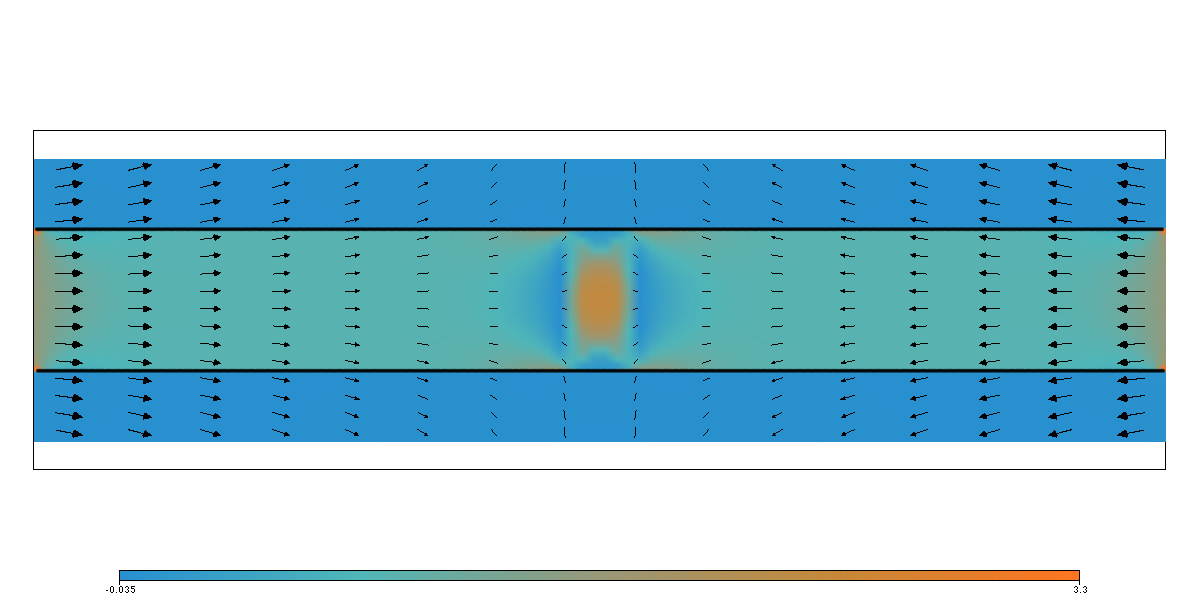

In [17]:
figVelocityPressure = glucifer.Figure( figsize=(1200,600), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )
figVelocityPressure.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
figVelocityPressure.append( glucifer.objects.Surface(mesh, pressureField) )
figVelocityPressure.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colourBar=False, colours="#440000 #440000") )
figVelocityPressure.show()


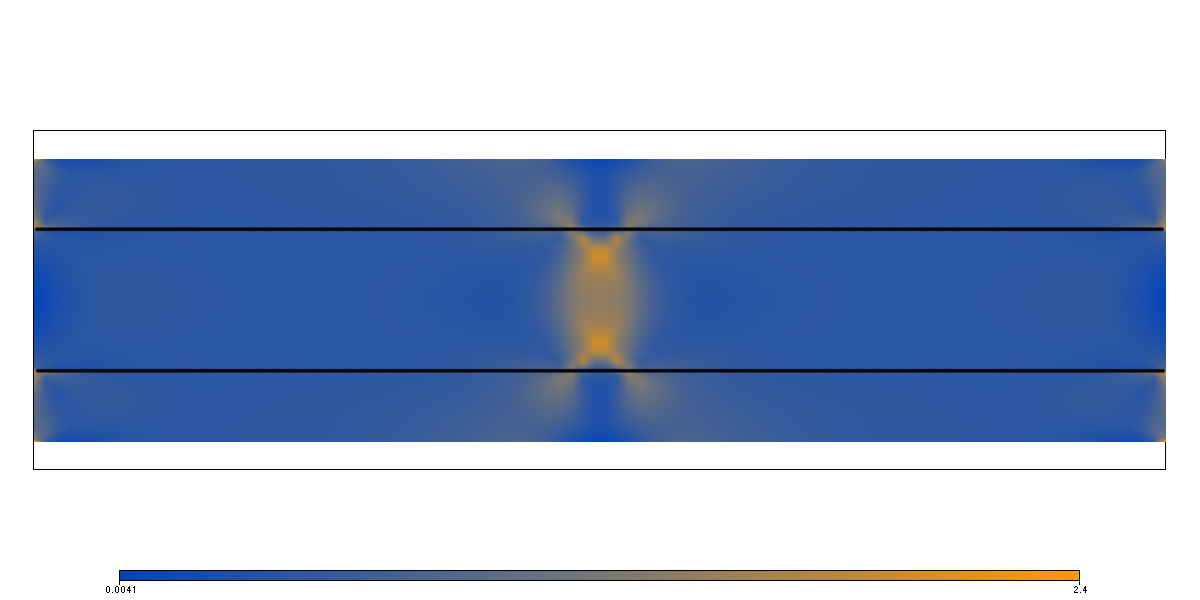

In [18]:
# The stress is only guaranteed to be accurate when integrated across an element. Fluctuations
# within an element can be significant. Mapping to the mesh can help

meshStrainRate  = uw.mesh.MeshVariable( mesh, 1 )

projectorStrainRate = uw.utils.MeshVariable_Projection( meshStrainRate, strainRate_2ndInvariantFn, type=1 )
projectorStrainRate.solve()

figMeshStrainRate = glucifer.Figure( figsize=(1200,600), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )
figMeshStrainRate.append( glucifer.objects.Surface(mesh, meshStrainRate  , colours="#0044BB, #777777, #FF9900") )
figMeshStrainRate.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colours="#440000 #440000", colourBar=False) )

figMeshStrainRate.show()

## Main simulation loop

To see if things are working correctly, we plot strain rate at (0.0, 0.5) which is at the centre of the aniso block as a function of the orientation of the director.  

We could specify the director as a function as there is no history or advection in the problem, but let's leave it as a swarm variable for now.



In [19]:
# Stepping. Initialise time and timestep.


orientationValues = []
strainRateValues  = []
stressValues      = []
velocityValues    = []


for orientationDegrees in range(0, 91, 1):
    
    orientation = -orientationDegrees * math.pi / 180.0 
    directorVector.data[:,0] = math.cos(orientation)
    directorVector.data[:,1] = math.sin(orientation)
    
    # Obtain V,P and remove null-space / drift in pressure
    
    solver.solve( nonLinearIterate=False )

    (area,)   = surfaceArea.evaluate()
    (p0,)     = surfacePressureIntegral.evaluate() 
  
    pressureField.data[:] -= p0 / area
           
    comm.Barrier()

    projectorStrainRate.solve()
    figMeshStrainRate.save_image(   outputPath + "figEdot-" + str(orientationDegrees) )
    figVelocityPressure.save_image( outputPath + "figVP-" + str(orientationDegrees) )
    
    strainRateCentral = strainRate_2ndInvariantFn.evaluate((0.,0.5))[0,0]
    velocityAssymmetry = velocityField.evaluate(( 0.1,0.5))[0,1]-velocityField.evaluate((-0.1,0.5))[0,1]
    devStressInvariantSquasher = 2.0 * viscosityV * strainRate_2ndInvariantFn.evaluate((-1.0,0.5))[0,0]
    
    orientationValues.append(orientationDegrees)
    strainRateValues.append(strainRateCentral)
    velocityValues.append(velocityAssymmetry)
    stressValues.append(devStressInvariantSquasher)

    if uw.rank()==0:   
             
        print('orientation = {:6d}; strain rate (central) = {:.5e}; deltaV = {:.5e}; devStress = {:.5e}'.format(
                    orientationDegrees, strainRateCentral, velocityAssymmetry, devStressInvariantSquasher))
              
              
              
    comm.Barrier()   
       
    
## Repeat ...     

orientation =      0; strain rate (central) = 5.15976e-01; deltaV = 5.61058e-09; devStress = 1.03176e+00
orientation =      1; strain rate (central) = 5.41891e-01; deltaV = -5.29040e-02; devStress = 1.03123e+00
orientation =      2; strain rate (central) = 6.12843e-01; deltaV = -1.05041e-01; devStress = 1.02967e+00
orientation =      3; strain rate (central) = 7.14896e-01; deltaV = -1.55683e-01; devStress = 1.02711e+00
orientation =      4; strain rate (central) = 8.35819e-01; deltaV = -2.04173e-01; devStress = 1.02362e+00
orientation =      5; strain rate (central) = 9.67458e-01; deltaV = -2.49943e-01; devStress = 1.01930e+00
orientation =      6; strain rate (central) = 1.10477e+00; deltaV = -2.92530e-01; devStress = 1.01424e+00
orientation =      7; strain rate (central) = 1.24462e+00; deltaV = -3.31569e-01; devStress = 1.00855e+00
orientation =      8; strain rate (central) = 1.38498e+00; deltaV = -3.66792e-01; devStress = 1.00236e+00
orientation =      9; strain rate (central) = 1

In [62]:
orientationArray = np.array(orientationValues)
strainRateArray  = np.array(strainRateValues)
deltaVArray      = np.array(velocityValues)
devStressArray   = np.array(stressValues)

np.savez(outputPath+"/TransIsoCompressionData.npz", angle=orientationArray, strainRate=strainRateArray, deltaV=deltaVArray, stress=devStressArray)

In [42]:
### ISOTROPIC equivalent cases 

ISOstokes = uw.systems.Stokes( velocityField  = velocityField, 
                                  pressureField  = pressureField,
                                  conditions     = [velocityBCs,],
                                  fn_viscosity   = firstViscosityFn, 
                                  fn_bodyforce  = None )


ISOsolver = uw.systems.Solver( ISOstokes )

## Initial solve (drop the non-linearity the very first solve only)
## Replace "lu" with "mumps" for parallel if you have it.

ISOsolver.set_inner_method("mumps")
ISOsolver.set_penalty(1.0e6)
ISOsolver.options.scr.ksp_rtol = 1.0e-3


## 1) Weak 

viscosityA   = 0.01
viscosityV   = 1.0
viscosityTI  = 0.1

viscosityMap  = { materialA: viscosityA,  materialV:viscosityV,  materialTI:viscosityTI  }


firstViscosityFn   = fn.branching.map( fn_key = materialVariable, 
                                       mapping = viscosityMap )


ISOstokes.fn_viscosity = firstViscosityFn

ISOsolver.solve( nonLinearIterate=False )

strainRateCentralWeakISORef = strainRate_2ndInvariantFn.evaluate((0.0,0.5))[0,0]
velocityAssymmetryWeakISORef = velocityField.evaluate(( 0.1,0.5))[0,1]-velocityField.evaluate((-0.1,0.5))[0,1]
stressWeakISORef = 2.0 * viscosityV * strainRate_2ndInvariantFn.evaluate((-1.0,0.5))[0,0]


## 2) Strong

viscosityA   = 0.01
viscosityV   = 1.0
viscosityTI  = 1.0

viscosityMap  = { materialA: viscosityA,  materialV:viscosityV,  materialTI:viscosityTI  }


firstViscosityFn   = fn.branching.map( fn_key = materialVariable, 
                                       mapping = viscosityMap )


ISOstokes.fn_viscosity = firstViscosityFn

ISOsolver.solve( nonLinearIterate=False )


strainRateCentralStrongISORef = strainRate_2ndInvariantFn.evaluate((0.0,0.5))[0,0]
velocityAssymmetryStrongISORef = velocityField.evaluate(( 0.1,0.5))[0,1]-velocityField.evaluate((-0.1,0.5))[0,1]
stressStrongISORef = 2.0 * viscosityV * strainRate_2ndInvariantFn.evaluate((-1.0,0.5))[0,0]

pass


In [30]:
print "Weak Ref values ", strainRateCentralWeakISORef, velocityAssymmetryWeakISORef, stressWeakISORef
print "Strong Ref values ", strainRateCentralStrongISORef, velocityAssymmetryStrongISORef, stressStrongISORef
print ""
print "Strain Rates min/max - ", strainRateArray.min(), strainRateArray.max()
print "Stresses min/max - ", devStressArray.min(), devStressArray.max()

 Weak Ref values  2.227951541 9.66110808036e-09 0.83913864845
Strong Ref values  0.515975659756 8.3854020783e-09 1.03175977378

Strain Rates min/max -  0.515975656522 2.59890144597
Stresses min/max -  0.900812208549 1.03175976981



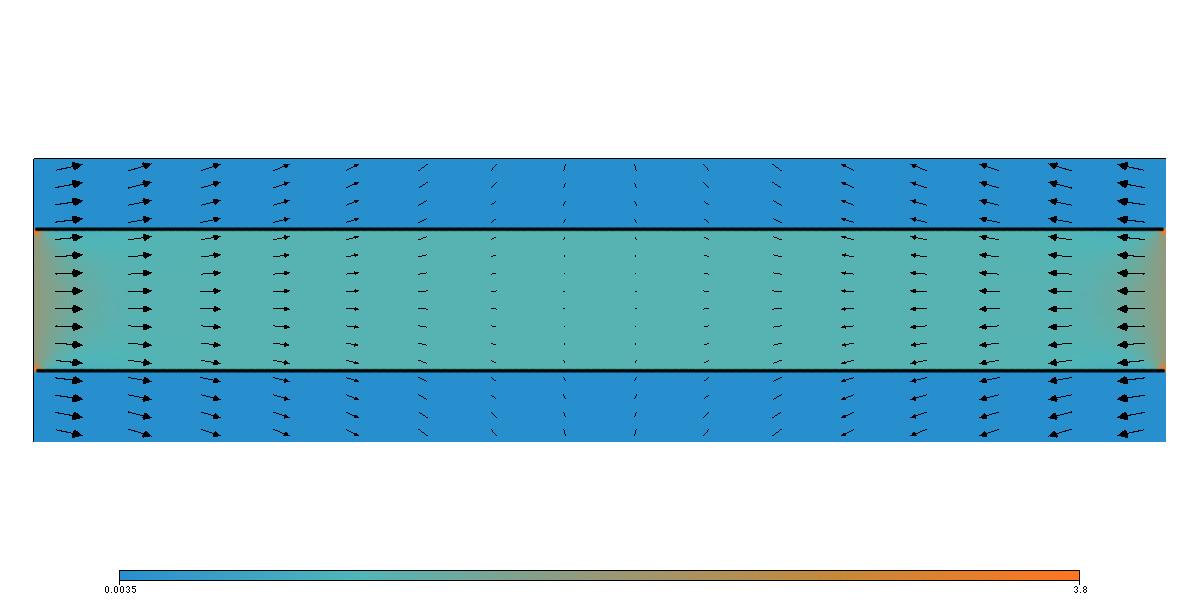

In [41]:
figISOVelocityPressure = glucifer.Figure( figsize=(1200,600), boundingBox=((-2.0, -0.0, 0.0), (2.0, 1.0, 0.0)) )
figISOVelocityPressure.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=.1) )
figISOVelocityPressure.append( glucifer.objects.Surface(mesh, pressureField) )
figISOVelocityPressure.append( glucifer.objects.Points(surfaceSwarm, pointSize=5.0, colourBar=False, colours="#440000 #440000") )
figISOVelocityPressure.show()

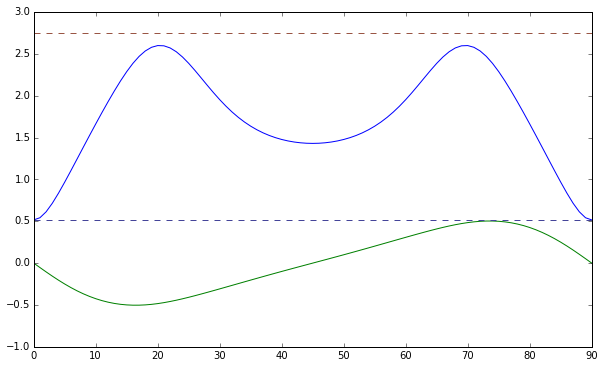

In [60]:
if comm.size == 1:   # Serial
    figEdot = pyplot.figure(figsize=(10,6))
    plot1 = figEdot.add_subplot(111)
    plot1.plot(orientationArray, strainRateArray)
    plot1.plot(orientationArray, deltaVArray)  
    plot1.plot([0.0,90.0], [strainRateCentralWeakISORef,strainRateCentralWeakISORef], color="#995544", linestyle="--")
    plot1.plot([0.0,90.0], [strainRateCentralStrongISORef,strainRateCentralStrongISORef], color="#444499", linestyle="--")
    figEdot.show()
    figEdot.savefig(outputPath+"TransIsoCompressionEdot")

    

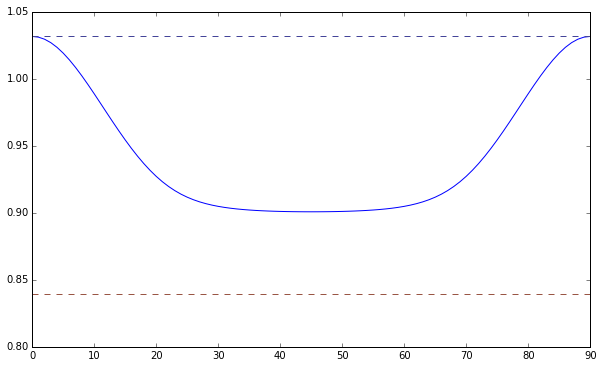

In [61]:
if comm.size == 1:   # Serial
    figSTR = pyplot.figure(figsize=(10,6))
    plot1 = figSTR.add_subplot(111)
    plot1.plot(orientationArray, devStressArray)    
    plot1.plot([0.0,90.0], [stressWeakISORef,stressWeakISORef], color="#995544", linestyle="--")
    plot1.plot([0.0,90.0], [stressStrongISORef,stressStrongISORef], color="#444499", linestyle="--")
    figSTR.show()
    figSTR.savefig(outputPath+"TransIsoCompressionStress")
